In [1]:
import numpy as np
import symlib
from mwgcs import SymphonyHaloProfile, NFW, Einasto
from gala.potential import NFWPotential, PlummerPotential
from gala.units import galactic
import matplotlib.pyplot as plt
import astropy.units as u
import asdf
from tqdm import tqdm
from scipy.optimize import curve_fit

from symlib import Jiang2019RHalf

sim_dir = "/fs/ddn/sdf/group/kipac/g/cosmo/ki21/phil1/simulations/ZoomIns/SymphonyMilkyWay/Halo023"

Gravitree path added to sys.path.


In [2]:
potential_catalog = asdf.open("tracked_potentials.asdf")

In [3]:
# masking parameters
mask_snapshot = True
mask_halo_id  = False

snapshot = 235
halo_id = 0

#####################
indices = None

if mask_snapshot and mask_halo_id: 
    indices = np.where((np.array(potential_catalog['snapshot']) == snapshot) & (np.array(potential_catalog['halo_id']) == halo_id))
elif mask_snapshot and not mask_halo_id:
    indices = np.where((np.array(potential_catalog['snapshot']) == snapshot))
elif not mask_snapshot and mask_halo_id:
    indices = np.where((np.array(potential_catalog['halo_id']) == halo_id))

snapshots = np.array(potential_catalog['snapshot'])[indices]
halo_ids  = np.array(potential_catalog['halo_id'])[indices]
fparams    = np.array(potential_catalog['fit_param'])[indices]
types     = np.array(potential_catalog['type'])[indices]

def update_halo_ids(snap):
    global halo_ids
    global indices
    global fparams
    global types
    global mask_snapshot
    global mask_halo_id
    global snapshots

    if mask_snapshot and mask_halo_id: 
        indices = np.where((np.array(potential_catalog['snapshot']) == snap) & (np.array(potential_catalog['halo_id']) == halo_id))
    elif mask_snapshot and not mask_halo_id:
        indices = np.where((np.array(potential_catalog['snapshot']) == snap))
    elif not mask_snapshot and mask_halo_id:
        indices = np.where((np.array(potential_catalog['halo_id']) == halo_id))

    snapshots = np.array(potential_catalog['snapshot'])[indices]
    halo_ids  = np.array(potential_catalog['halo_id'])[indices]
    fparams    = np.array(potential_catalog['fit_param'])[indices]
    types     = np.array(potential_catalog['type'])[indices]

In [4]:
rs, hist = symlib.read_rockstar(sim_dir)

um = symlib.read_um(sim_dir)

params = symlib.simulation_parameters(sim_dir)
scale_factors = symlib.scale_factors(sim_dir)
mp = params['mp'] / params['h100']
particle_class = symlib.Particles(sim_dir)

particles = particle_class.read(snapshot, mode='all')

loaded_snapshot = snapshot

def load_particles(s):
    global loaded_snapshot
    global particles
    if s != loaded_snapshot:
        particles = particle_class.read(s, mode='all')
        loaded_snapshot = s

def getPlummerAcceleration(r, mass, rvir, cvir, z):
    rhalf_model = Jiang2019RHalf(scatter = 0.2)
    r_half = rhalf_model.r_half(rvir, cvir, z)
    b = r_half / 1.3
    _pot = PlummerPotential(mass, b, units=galactic)
    accel = _pot.acceleration([r, 0.*r, 0.*r]).to(u.km/u.s**2).value[0, :]
    return accel

In [5]:
def plot_density(halo_id, snapshot, ax):
    load_particles(snapshot)
    halo_index = np.where((halo_ids == halo_id) & (snapshots == snapshot))
    
    q = particles[halo_id]['x']
    q_sh = rs[halo_id, snapshot]['x']
    profile = SymphonyHaloProfile(q, q_sh, mp, rs[halo_id, snapshot]['rvir'])
    bin_radius, bin_density = profile.getDensityProfile(40)

    ax.loglog(bin_radius, bin_density, label='sym', c='blue', marker='o')
    
    rvir, cvir, mvir = rs[halo_id, snapshot]['rvir'], rs[halo_id, snapshot]['cvir'], rs[halo_id, snapshot]['m']
    nfw     = NFW(mvir, rvir, cvir)
    nfw_density = nfw.density(bin_radius)
    ax.loglog(bin_radius, nfw_density, label='nfw profile', c='orange')
    
    if types[halo_index] == 'einasto':
        fp = fparams[halo_index][0]
        
        einasto = Einasto(fp['alpha'], fp['Rs'], fp['logScaleDensity'])
        einasto_density = einasto.density(bin_radius)
        ax.loglog(bin_radius, einasto_density, ls='--', c='r', label='einasto fit')

    ax.legend()
    ax.set_xlabel(r'$r$ [kpc]')
    ax.set_ylabel(r'$\rho(r)$ $[\mathrm{M_\odot / kpc^3}]$')

def plot_accel(halo_id, snapshot, ax):
    load_particles(snapshot)
    halo_index = np.where((halo_ids == halo_id) & (snapshots == snapshot))
    
    q = particles[halo_id]['x']
    q_sh = rs[halo_id, snapshot]['x']
    profile = SymphonyHaloProfile(q, q_sh, mp, rs[halo_id, snapshot]['rvir'])

    radii = np.logspace(-3, 2, 1000)
    menc = np.array([profile.menc(r_i) for r_i in radii])
    _g_accel = 1.3938323614347172e-22 # ((u.kpc**2 / u.Msun) * (u.km/u.s**2))
    accel = _g_accel * menc / radii**2
    
    rvir, cvir, mvir = rs[halo_id, snapshot]['rvir'], rs[halo_id, snapshot]['cvir'], rs[halo_id, snapshot]['m']
    nfw     = NFW(mvir, rvir, cvir)
    nfw_accel = np.array([nfw.acceleration(r_i) for r_i in radii])

    ax.loglog(radii, np.abs(accel), label='symphony', c='blue')
    ax.loglog(radii, np.abs(nfw_accel), label='nfw', c='orange')
    
    if types[halo_index] == 'einasto':
        fp = fparams[halo_index][0]
        einasto = Einasto(fp['alpha'], fp['Rs'], fp['logScaleDensity'])
        einasto_accel = np.array([einasto.acceleration(r_i) for r_i in radii])
        ax.loglog(radii, np.abs(einasto_accel), ls='--', c='r', label='einasto fit')

    ax.legend()
    ax.set_xlabel(r'$r$ [kpc]')
    ax.set_ylabel(r'$|a_r| \, \mathrm{[km / s^2]}$')

def plot_rho_acc(halo_id, snapshot, axs, make_legend=False):

    load_particles(snapshot)
    
    halo_index = np.where((halo_ids == halo_id) & (snapshots == snapshot))[0]
    
    q = particles[halo_id]['x']
    q_sh = rs[halo_id, snapshot]['x']
    profile = SymphonyHaloProfile(q, q_sh, mp, rs[halo_id, snapshot]['rvir'])
    
    softening = params['eps']/params['h100'] * scale_factors[snapshot]

    bin_radius, bin_density = profile.getDensityProfile(40)
    
    radii = np.logspace(-3, 2, 1000)
    menc = np.array([profile.menc(r_i) for r_i in radii])
    _g_accel = 1.3938323614347172e-22 # ((u.kpc**2 / u.Msun) * (u.km/u.s**2))
    accel = _g_accel * menc / (radii**2 + softening**2)
    
    
    rvir, cvir, mvir = rs[halo_id, snapshot]['rvir'], rs[halo_id, snapshot]['cvir'], rs[halo_id, snapshot]['m']
    nfw     = NFW(mvir, rvir, cvir)
    nfw_accel = np.array([nfw.acceleration(r_i, softening) for r_i in radii])
    nfw_density = nfw.density(bin_radius)

    mstar = um[halo_id, snapshot]['m_star']
    z = (1/scale_factors[snapshot]) - 1
    
    plummer_accel = getPlummerAcceleration(radii, mstar, rvir, cvir, z)

    logr, loga = np.log10(radii), np.log10(accel)
    
    fit_mask = (logr > -.5) & (np.isfinite(loga))
    
    def polynomial(x, *params):
        a, b, c, d = params
        fun = (a*x**3 + b*x**2 + c*x + d)
        return fun

    DEG = 3
    
    p = np.polyfit(logr[fit_mask], loga[fit_mask], DEG)

    print("polyfit ", p)
    
    # use polyfit from np
    # popt, pcov = curve_fit(polynomial, logr[fit_mask], loga[fit_mask], p0=(-.5, 1., 1., -13.), nan_policy='omit', maxfev=10000)
    
    axs[0].loglog(bin_radius, bin_density, label='sym', c='blue', marker='o')
    axs[0].loglog(bin_radius, nfw_density, label='nfw profile', c='orange')
    
    
    nan_mask = np.isinf(loga)
    axs[1].loglog(10**logr[~nan_mask], 10**polynomial(logr, *p)[~nan_mask], c='green', ls='-.', label='poly')
    
    axs[1].loglog(radii, np.abs(accel), label='symphony', c='blue', alpha=.5)
    axs[1].loglog(radii, np.abs(nfw_accel), label='nfw', c='orange')
    axs[1].loglog(radii, np.abs(plummer_accel), label='plummer', c='grey', ls='-.')
    
    if types[halo_index] == 'einasto':
        fp = fparams[halo_index][0]
        einasto = Einasto(fp['alpha'], fp['Rs'], fp['logScaleDensity'])
        einasto_density = einasto.density(bin_radius)
        einasto_accel = np.array([einasto.acceleration(r_i, softening) for r_i in radii])
        axs[0].loglog(bin_radius, einasto_density, ls='--', c='r', label='einasto fit')
        axs[1].loglog(radii, np.abs(einasto_accel), ls='--', c='r', label='einasto fit')

    if make_legend:
        axs[0].legend()
    
    axs[0].set_xlabel(r'$r$ [kpc]')
    axs[0].set_ylabel(r'$\rho(r)$ $[\mathrm{M_\odot / kpc^3}]$')
    
    axs[1].legend()
    axs[1].set_xlabel(r'$r$ [kpc]')
    axs[1].set_ylabel(r'$|a_r| \, \mathrm{[km / s^2]}$')

    ##### textual information #####
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    axs[0].text(0.05, 0.1, r"$\log_{{10}} (M_h / \mathrm{{M_\odot}}) = {:.2f}$".format(np.log10(rs[halo_id, snapshot]['m'])), va='top', bbox=props, transform=axs[0].transAxes)

In [6]:
def split_k(array, k=4):
    # Use list comprehension to create groups of four
    return [array[i:i + k] for i in range(0, len(array), k)]

In [7]:
def make_plot(halo_ids, snapshot, write_dir="./", k=0):
    fig, axs = plt.subplots(2, 6, figsize=(30, 8), dpi=300)

    plot_rho_acc(halo_ids[0], snapshot, axs[:, 0], True)
    plot_rho_acc(halo_ids[1], snapshot, axs[:, 1])
    plot_rho_acc(halo_ids[2], snapshot, axs[:, 2])
    plot_rho_acc(halo_ids[3], snapshot, axs[:, 3])
    plot_rho_acc(halo_ids[4], snapshot, axs[:, 4])
    plot_rho_acc(halo_ids[5], snapshot, axs[:, 5])

    # fig.subplots_adjust(hspace=0.)

    redshift = 1/(scale_factors[snapshot]) - 1
    fig.suptitle(r"$z = {:.2f}$".format(redshift))
    filename = "rho_accel_z{:.2f}_{}.pdf".format(redshift, k)
    plt.savefig(write_dir + filename)

  0%|          | 0/2 [00:00<?, ?it/s]/lscratch/jaymarie/tmp/ipykernel_1385776/3893201410.py:88: RuntimeWarning: divide by zero encountered in log10
  logr, loga = np.log10(radii), np.log10(accel)


polyfit  [  0.1135634   -0.65742625   0.32363439 -12.96328725]
polyfit  [ 1.38401933e-01 -8.17791272e-01  1.01556591e-02 -1.33087220e+01]
polyfit  [  0.13620162  -0.81510447   0.14622128 -13.4401011 ]
polyfit  [  0.1959062   -1.07398819   0.14966999 -13.61082256]
polyfit  [ 4.44587354e-01 -1.49539775e+00  4.10464657e-03 -1.34512795e+01]
polyfit  [  0.61877996  -1.79785204  -0.12140305 -13.63869679]



 50%|█████     | 1/2 [01:12<01:12, 72.40s/it]

Subhalo has insufficient particle count, rebinning with  35  bins


/lscratch/jaymarie/tmp/ipykernel_1385776/3893201410.py:88: RuntimeWarning: divide by zero encountered in log10
  logr, loga = np.log10(radii), np.log10(accel)


polyfit  [  0.72354605  -2.80403665   1.97267822 -16.36809902]
polyfit  [  0.546019    -1.70737294  -0.2942978  -14.61524835]


/sdf/home/j/jaymarie/mwgcs/mwgcs/fit.py:325: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  menc = quad(integ, 0, r)[0]


polyfit  [  0.49402127  -1.49690477  -0.52929044 -14.59918969]
polyfit  [  0.56139928  -1.55135     -0.70268211 -14.58888413]
polyfit  [  0.24603527  -0.79879963  -0.80591314 -14.68308575]
polyfit  [  0.38052509  -1.17573689  -0.8673561  -14.68891551]



  0%|          | 0/2 [00:00<?, ?it/s]/sdf/home/j/jaymarie/mwgcs/mwgcs/fit.py:325: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  menc = quad(integ, 0, r)[0]
/lscratch/jaymarie/tmp/ipykernel_1385776/3893201410.py:88: RuntimeWarning: divide by zero encountered in log10
  logr, loga = np.log10(radii), np.log10(accel)


polyfit  [  0.35692162  -0.95732434  -0.65285103 -13.37329505]
polyfit  [  0.65538578  -1.28391382  -1.2805482  -13.94929513]
polyfit  [  0.44295393  -1.12566971  -1.09445653 -13.49079031]
polyfit  [  0.29081376  -1.05014153  -0.81982684 -13.29225651]
polyfit  [  0.26481546  -0.87441806  -1.13105841 -13.70161727]
polyfit  [  0.32575102  -0.94617846  -1.04401979 -13.82444971]



 50%|█████     | 1/2 [01:31<01:31, 91.73s/it]

Subhalo has insufficient particle count, rebinning with  15  bins


/lscratch/jaymarie/tmp/ipykernel_1385776/3893201410.py:88: RuntimeWarning: divide by zero encountered in log10
  logr, loga = np.log10(radii), np.log10(accel)


polyfit  [  0.0973097   -0.40568981  -1.47175352 -14.9964964 ]
polyfit  [  0.07798075  -0.23120994  -1.82463543 -14.60843514]
Subhalo has insufficient particle count, rebinning with  24  bins
polyfit  [  0.1378408   -0.40734221  -1.69325559 -14.83820284]
Subhalo has insufficient particle count, rebinning with  5  bins


/sdf/home/j/jaymarie/mwgcs/mwgcs/fit.py:325: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  menc = quad(integ, 0, r)[0]


polyfit  [  0.1554951   -0.47926476  -1.60565035 -15.23538376]
Subhalo has insufficient particle count, rebinning with  30  bins
polyfit  [  0.22858956  -0.76216831  -1.26491709 -14.64013113]
Subhalo has insufficient particle count, rebinning with  16  bins
polyfit  [  0.06120721  -0.17782543  -1.87130297 -15.05805911]



100%|██████████| 2/2 [06:11<00:00, 185.89s/it]


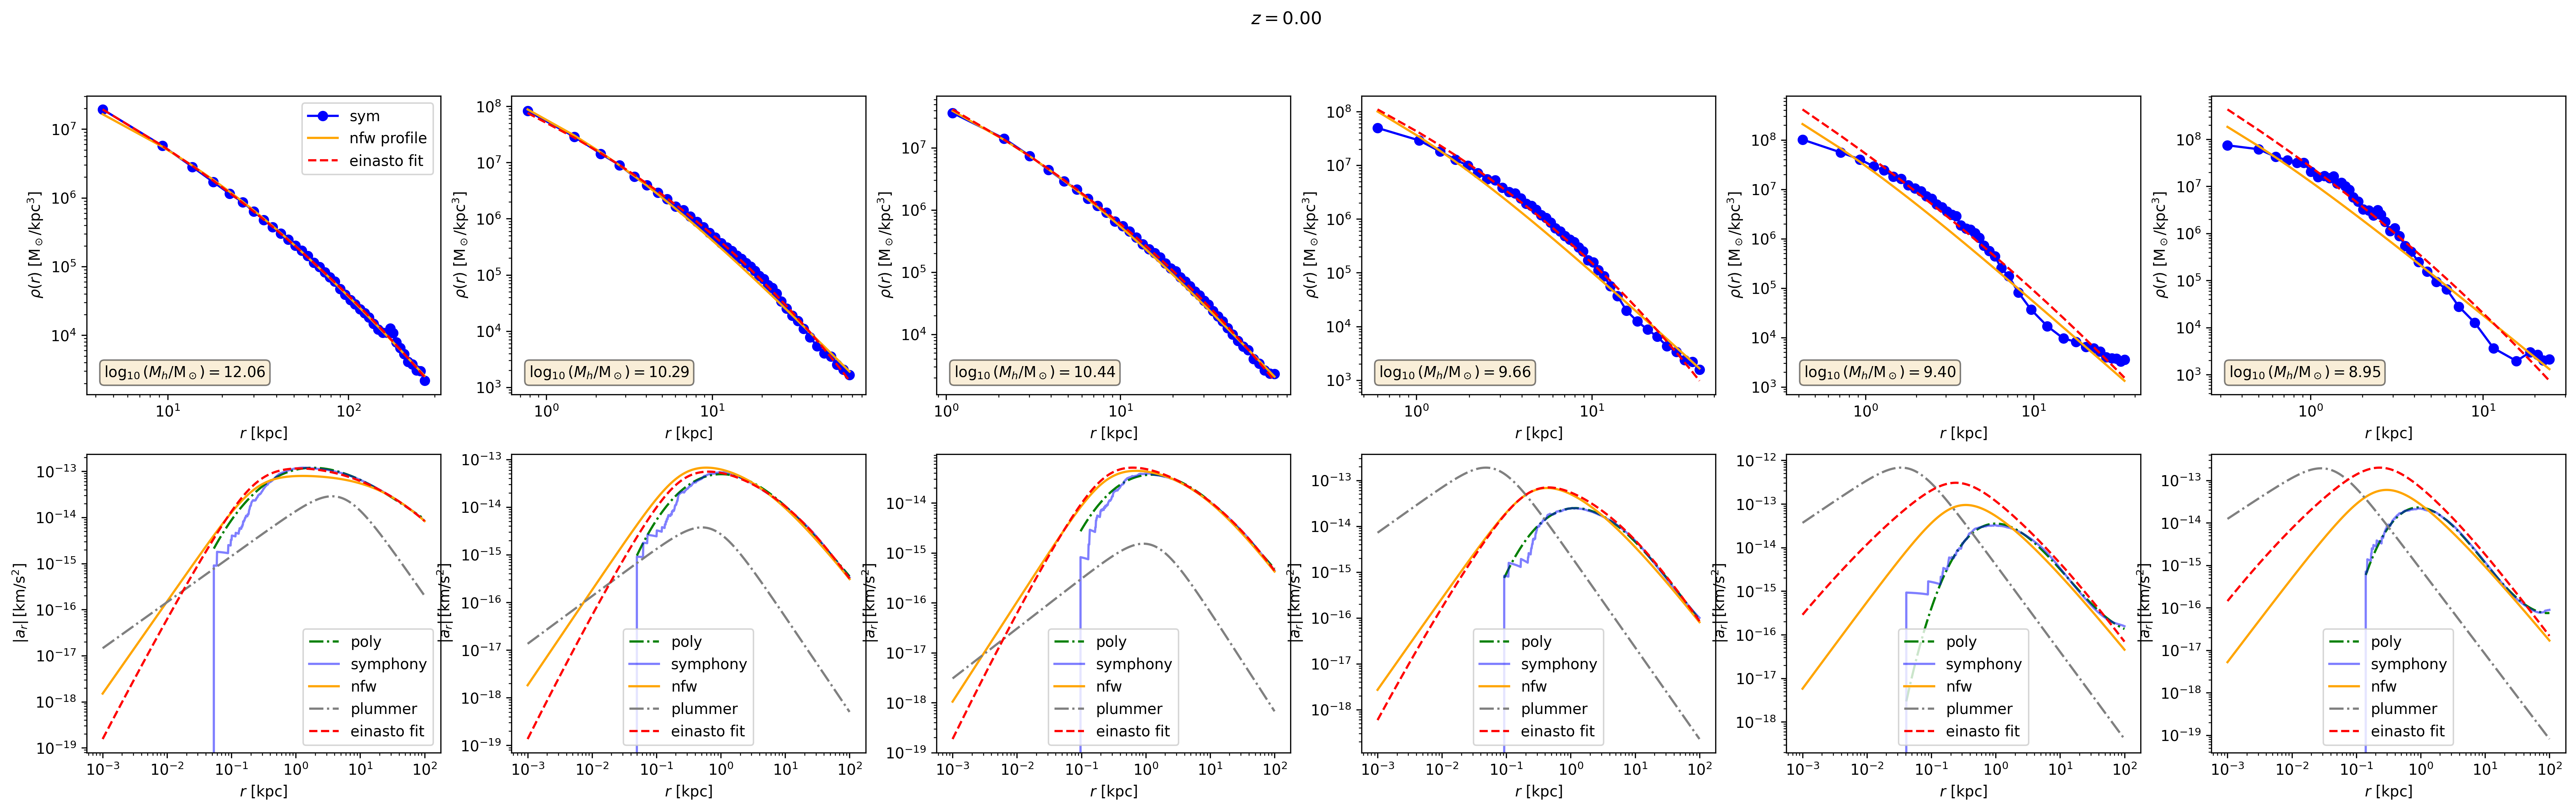

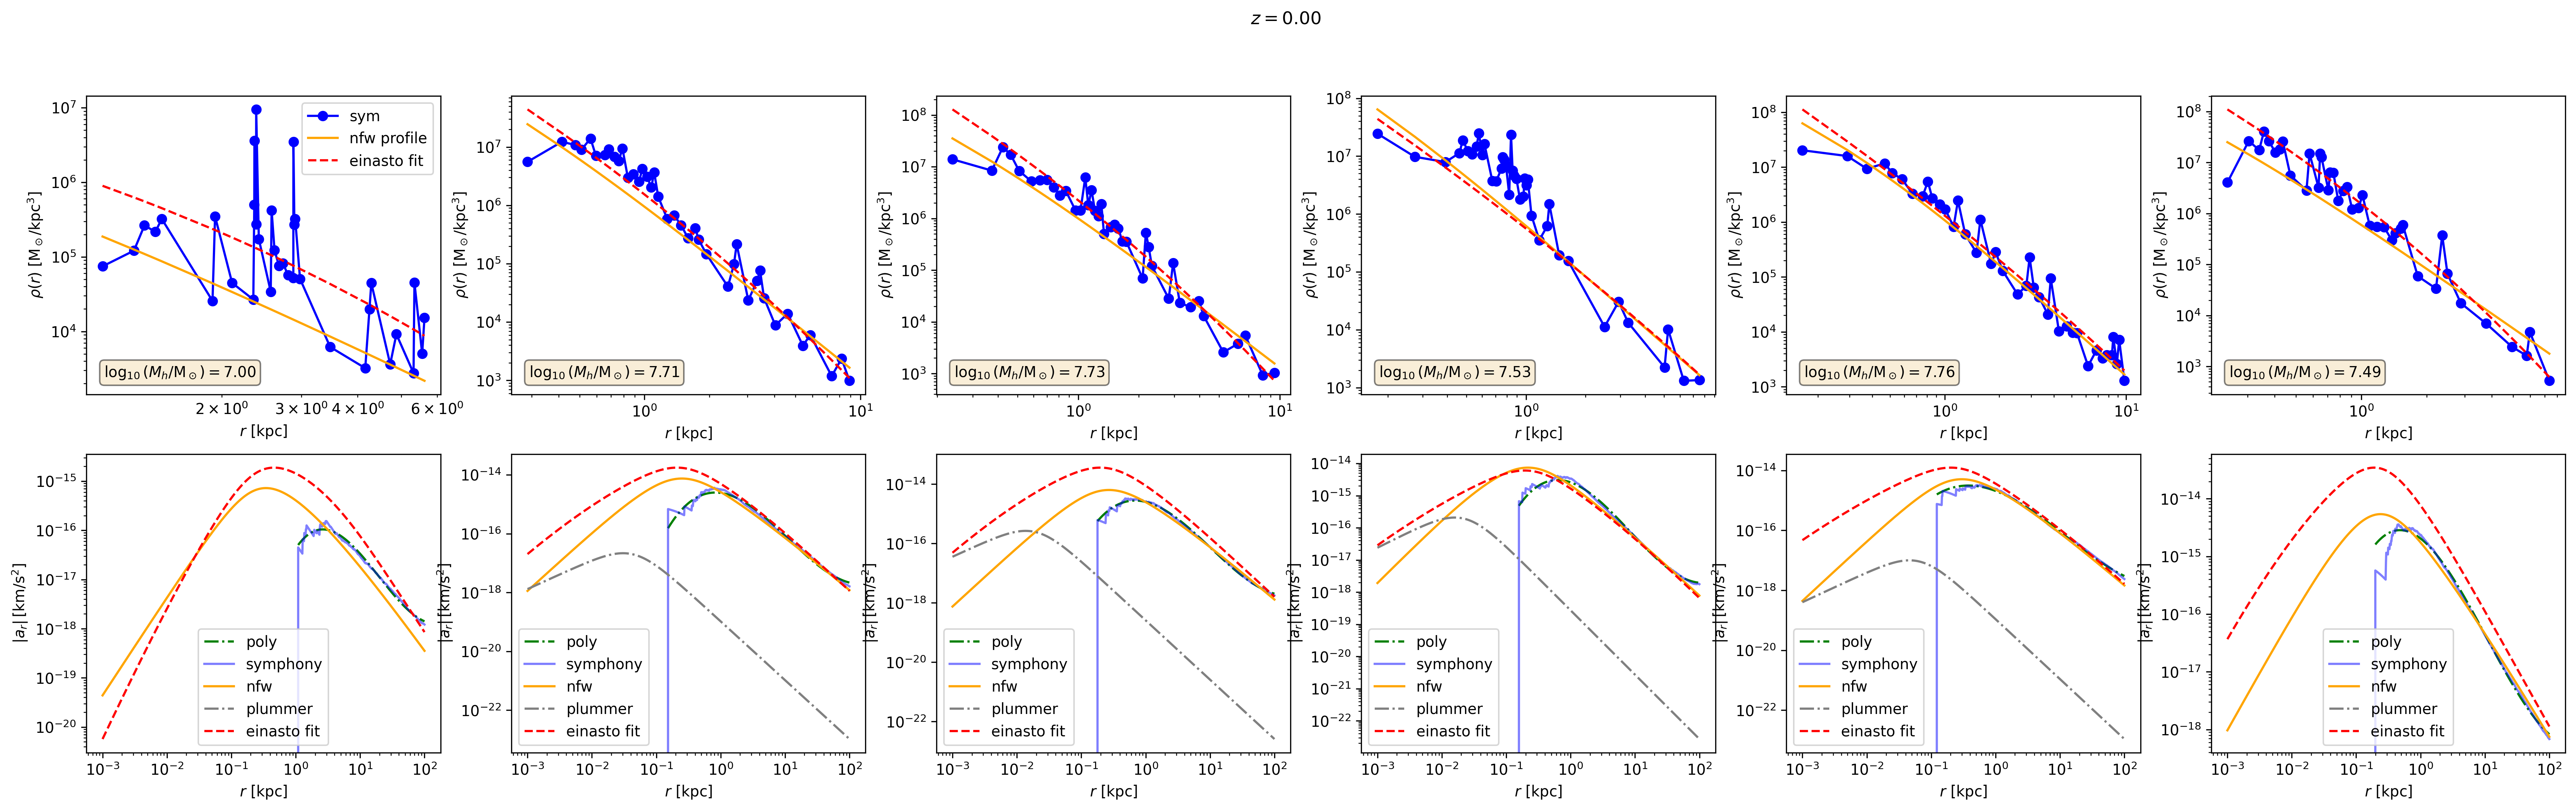

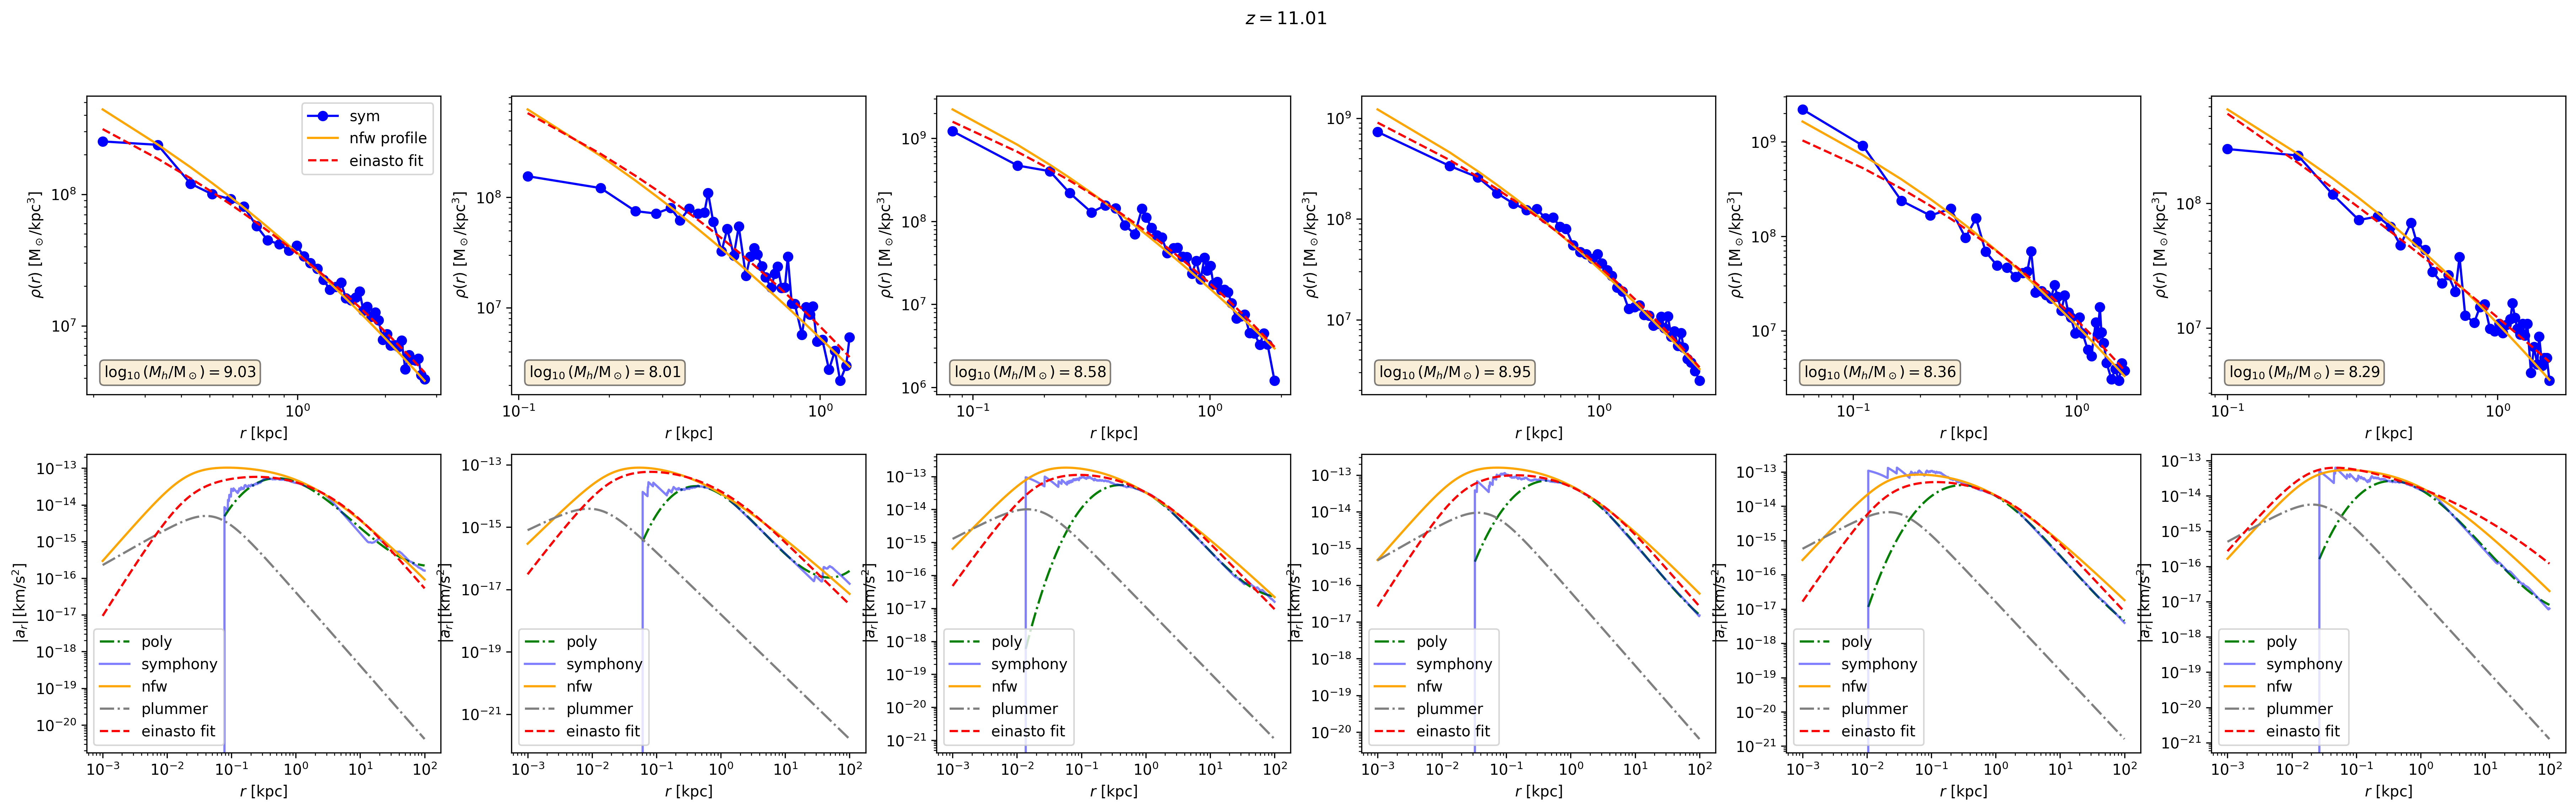

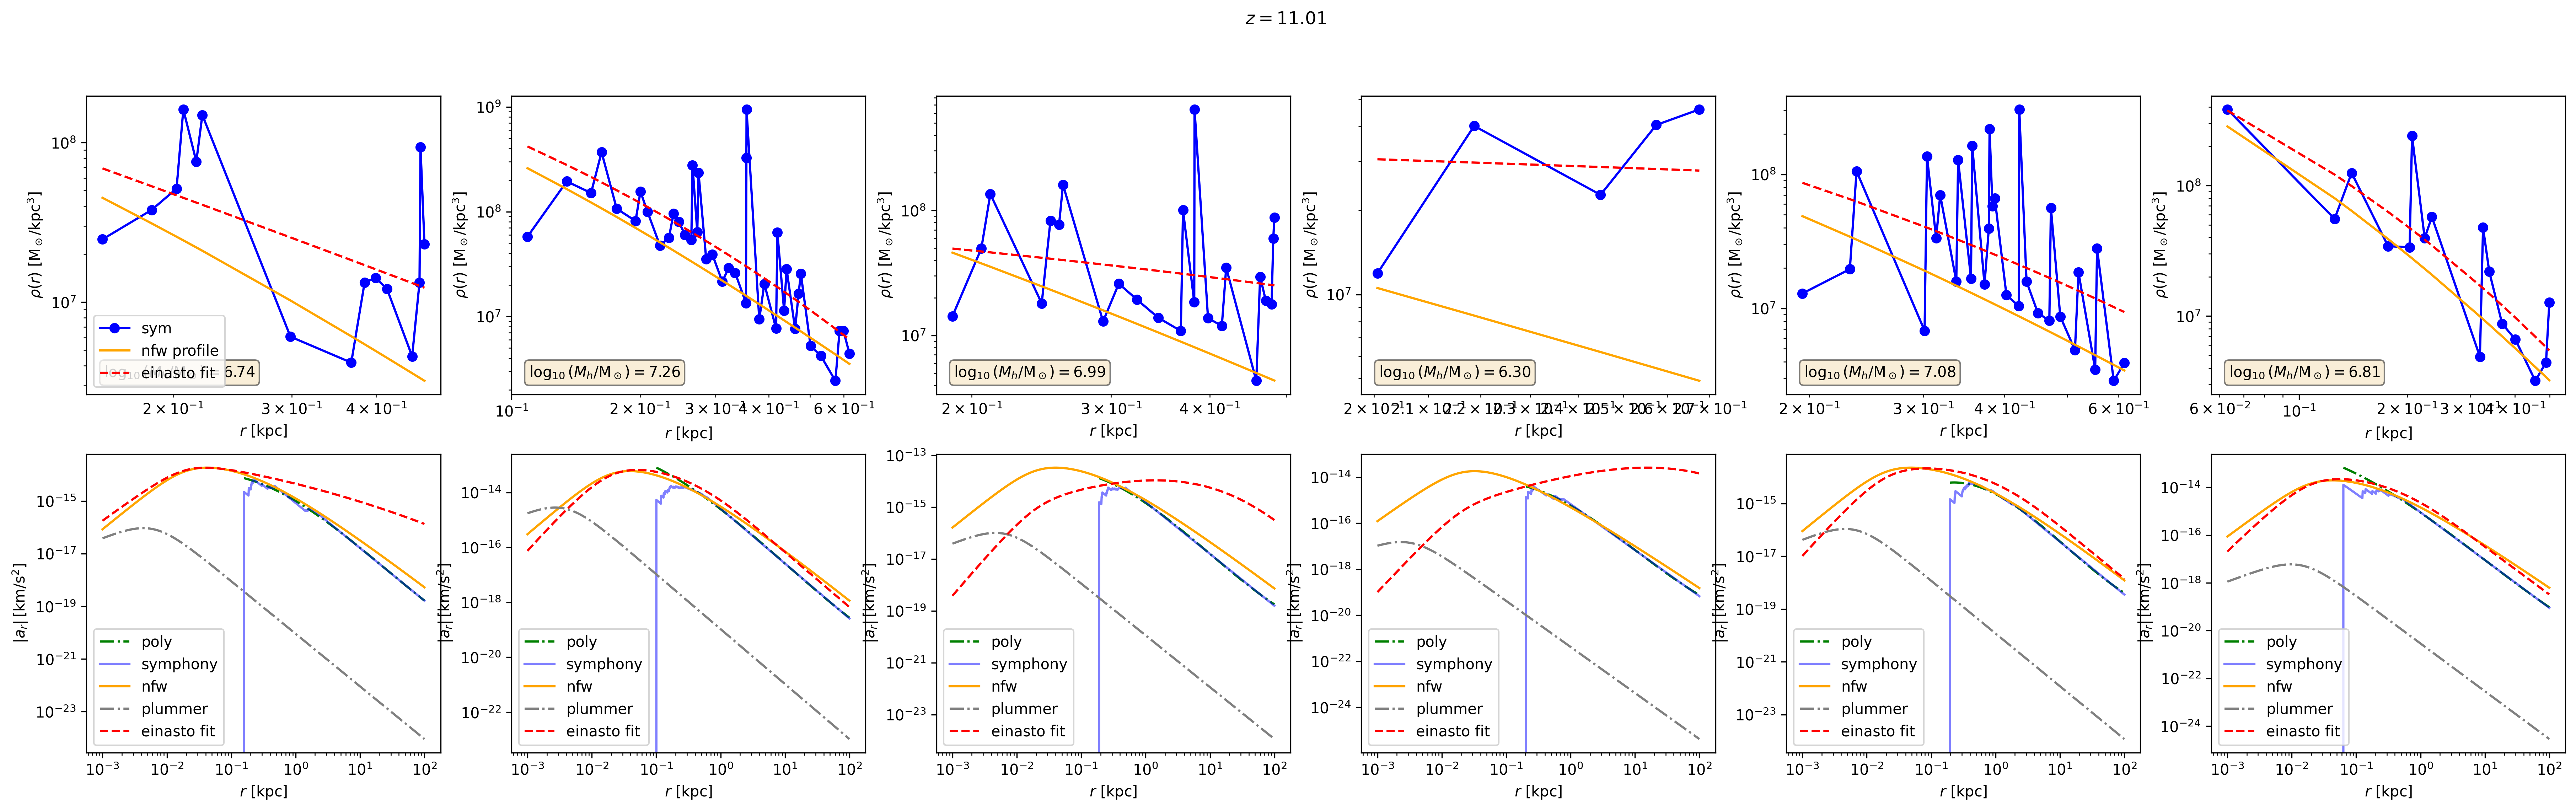

In [8]:
# loop
# snaps = [235, 200, 150, 80, 40]
snaps = [235, 40]

for snap in tqdm(snaps):
    update_halo_ids(snap)
    # split_ids = split_k(halo_ids, 6)
    # split_ids = np.hstack([split_ids[:2], split_ids[-2:]])
    _ids = [halo_ids[:6], halo_ids[-6:]]
    for k, _id in enumerate(tqdm(_ids)):
        make_plot(_id, snap, "./potential_fits/", k)

debug `z=0, halo 410`

Subhalo has insufficient particle count, rebinning with  35  bins


/lscratch/jaymarie/tmp/ipykernel_1154364/3893201410.py:88: RuntimeWarning: divide by zero encountered in log10
  logr, loga = np.log10(radii), np.log10(accel)


polyfit  [  0.72508022  -2.81009476   1.98003846 -16.37072509]


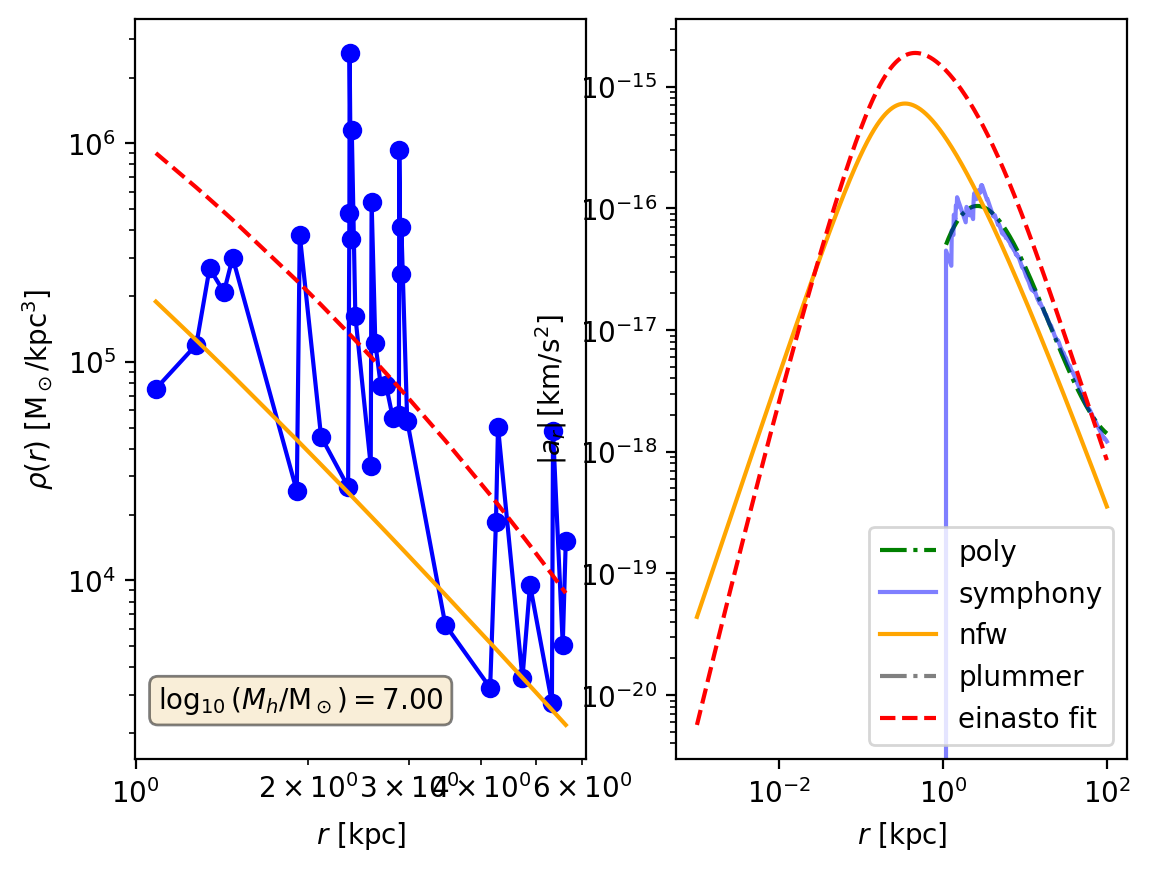

In [12]:
fig, ax = plt.subplots(1, 2, dpi=200)

plot_rho_acc(410, 235, ax)

plt.show()